# Dependencies

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

# NeuralNet class

In [63]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, layers_d, normalize = True, learning_rate = 0.01, num_iter = 30000, epsilon = (10)^(-8), betha_1 = 0.9, betha_2 = 0.999, k = 500):
        self.layers_d = layers_d # тут лише приховані шари а 0-го та останнього (з одним нейроном) немає
        self.L = len(self.layers_d) + 1 # кількість шарів нейронів в мережі без урахування вихідного
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.epsilon = epsilon
        self.betha_1 = betha_1
        self.betha_2 = betha_2
        self.k = k
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        '''
        X.shape =  (n, m)
        '''
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
            '''
            m.shape =  (n, 1)
            '''
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
            '''
            s.shape =  (n, 1)
            '''
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self, Z):
        
        x = np.exp(Z)        
        '''
        Z_i.shape  = (n_l, 1)
        x.shape = (n_l, 1)
        '''
        return x / np.sum(x, axis=0, keepdims = True)
    
    def __initialize_parameters(self):
        
        self.parameters = {} 
        # стоврюємо словник зі значеннями W_i та b_i,ключами в якому будуть назви W_1, w_2, ... та b_1, b_2 і т.д
        self.adam = {}
        
            
        for i in range(1, self.L + 1):
            
            self.adam['VdW_' + str(i)] = 0
            self.adam['SdW_' + str(i)] = 0
            
            self.adam['Vdb_' + str(i)] = 0            
            self.adam['Sdb_' + str(i)] = 0

            self.parameters['W_' + str(i)] = np.random.randn(self.layers_d[i], self.layers_d[i - 1])* np.sqrt(2/self.layers_d[i - 1])
            '''
            W_i.shape  = (n_l, n_l-1) # (кількість нейронів на поточному шарі, кількість на попередньому)
            '''
            self.parameters['b_' + str(i)] = np.zeros((self.layers_d[i],1))
            '''
            b_i.shape  = (n_l,1) # (кількість нейронів на поточному шарі, 1)
            '''
       
    def __forward_propagation(self, X):
        
        cache = {} # стоврюємо словник зі значеннями Z_i та A_i,ключами в якому будуть назви A_0, A_1, A_2, ... та Z_1, Z_2 і т.д
        cache['A_0'] = X
        
        for i in range(1, self.L):
            cache['Z_' + str(i)] = np.dot(self.parameters['W_' + str(i)], cache['A_' + str(i - 1)]) + self.parameters['b_' + str(i)]
            '''
            Z_i.shape  = (n_l, 1) = (n_l, n_l-1) * (n_l-1, 1) + (n_l,1)
            '''
            cache['A_' + str(i)] = self.__sigmoid(cache['Z_' + str(i)])
            '''
            A_i.shape  = (n_l, 1) = (n_l, 1)
            '''       
        cache['Z_' + str(self.L)] = np.dot(self.parameters['W_' + str(self.L)], cache['A_' + str(self.L - 1)]) + self.parameters['b_' + str(self.L)]
        cache['A_' + str(self.L)] = self.__softmax(cache['Z_' + str(self.L)])
        '''
        функція softmax на останньому кроці 
        ''' 
        return cache['A_' + str(self.L)], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        '''
        J.shape  = sum((1, m) x (1, m) - (1, m) x (1, m)) = sum((1, m)) = (1, 1)
        '''
        return J
        
    def __backward_propagation(self, X, Y, cache):
        
        m = X.shape[1]
        gradients = {}
        
        gradients['dZ_' + str(self.L)] = cache['A_' + str(self.L)] - Y
        '''
        dZ_L.shape  = (1, m) - (1, m) = (1, m)
        '''
        gradients['dW_' + str(self.L)] = (1/m) * np.dot (gradients['dZ_' + str(self.L)], cache['A_' + str(self.L - 1)].T)
        '''
        dW_L.shape  = (1, m) * ((n_l-1, m).T) = (1, m) * (m, n_l-1) = (1, n_l-1)
        '''
        gradients['db_' + str(self.L)] = (1/m) * np.sum(gradients['dZ_' + str(self.L)], axis = 1, keepdims = True)
        '''
        db_L.shape  = sum((1, m)) = (1, 1)
        '''
        
        for i in range(self.L - 1, 0, -1):
            dA_i = np.dot (self.parameters['W_' + str(i + 1)].T, gradients['dZ_' + str(i + 1)])
            '''
            dA_i.shape  = (n_l-1, n_l)*(n_l, m) = (n_l-1, m)
            '''
            gradients['dZ_' + str(i)] = np.multiply(dA_i, cache['A_' + str(i)] * (1 - cache['A_' + str(i)]))
            '''
            dZ_i.shape  = (n_l, m)x(n_l, m) = (n_l, m)
            '''
            gradients['dW_' + str(i)] = (1/m) * np.dot (gradients['dZ_' + str(i)], cache['A_' + str(i - 1)].T)
            '''
            dW_i.shape  = (n_l, m)*((n_l-1, n).T) = (n_l, m)*(m, n_l-1) = (n_l, n_l-1)
            '''
            gradients['db_' + str(i)] = (1/m) * np.sum(gradients['dZ_' + str(i)], axis = 1, keepdims = True)
            '''
            db_i.shape = sum((n_l, m)) = (n_l, 1)
            '''       
        
        return gradients
    
    def __update_parameters(self, gradients, t):
          
        for i in range(1, self.L + 1):            
            '''
            self.adam['VdW_' + str(i)] = np.multiply(self.betha_1, self.adam['VdW_' + str(i)]) + (1 - self.betha_1) * gradients['dW_' + str(i)]  
            self.adam['SdW_' + str(i)] = np.multiply(self.betha_2, self.adam['SdW_' + str(i)]) + (1 - self.betha_2) * np.power(gradients['dW_' + str(i)], 2)
            
            self.adam['VdW_corr_' + str(i)] = (self.adam['VdW_' + str(i)]) / (1 - np.power(self.betha_1, (t + 1)))
            self.adam['SdW_corr_' + str(i)] = (self.adam['SdW_' + str(i)]) / (1 - np.power(self.betha_2, (t + 1)))
            
            self.parameters['W_' + str(i)] = self.parameters['W_' + str(i)] - (self.learning_rate * self.adam['VdW_corr_' + str(i)] ) / (np.sqrt(self.adam['SdW_corr_' + str(i)]) + self.epsilon)
            '''
            #W_i.shape  = (n_l, n_l-1) # (кількість нейронів на поточному шарі, кількість на попередньому)
            '''

            self.adam['Vdb_' + str(i)] =  np.multiply(self.betha_1, self.adam['Vdb_' + str(i)]) + (1 - self.betha_1) * gradients['db_' + str(i)]  
            self.adam['Sdb_' + str(i)] =  np.multiply(self.betha_2, self.adam['Sdb_' + str(i)]) + (1 - self.betha_2) * np.power(gradients['db_' + str(i)], 2)          
            
            self.adam['Vdb_corr_' + str(i)] = (self.adam['Vdb_' + str(i)]) / (1 - np.power(self.betha_1, (t + 1)))          
            self.adam['Sdb_corr_' + str(i)] = (self.adam['Sdb_' + str(i)]) / (1 - np.power(self.betha_2, (t + 1)))

            self.parameters['b_' + str(i)] = self.parameters['b_' + str(i)] - (self.learning_rate * self.adam['Vdb_corr_' + str(i)]) / (np.sqrt(self.adam['Sdb_corr_' + str(i)]) + self.epsilon)
            
            '''
            #b_i.shape  = (n_l,1) # (кількість нейронів на поточному шарі, 1)
            '''
            '''
           
            
            self.parameters['W_' + str(i)] -= self.learning_rate * gradients['dW_' + str(i)]
            self.parameters['b_' + str(i)] -= self.learning_rate * gradients['db_' + str(i)]
          
           
        
    
    def fit(self, X_vert, Y_vert, print_cost = True):
        X= X_vert.T
        
        n_x = X.shape[0] # визначаємо кількість нейронів у вихідному шарі
                
        lb = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False) 
        # задаємо перетворення приналежності до класів як 0 і 1 відвідно для кожного прикладу 
        #([0, 0, 1] - приклад з класу 2, [1, 0, 0] - приклад з класу 0, [0, 1, 0] - приклад з класу 1)
        lb.fit(Y_vert)
        
        Y = lb.transform(Y_vert).T        
        final_classes = Y.shape[0] # визначаємо кількість нейронів у вихідному шарі
        
        self.layers_d.insert(0, n_x)
        self.layers_d.append(final_classes) 
        '''
        додаємо вхідний та вихідний шари до прихованих 
        і отримуємо клькість всіх шарів нейронної мережі і кількість нейронів на кожному шарі
        '''
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters()
        
        previous_cost = 0;

        for i in range(self.num_iter):
            
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            gradients = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(gradients, i)

            if print_cost and i % 1 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1 == 0:
                costs.append(cost)
            if (abs(previous_cost - cost) < self.epsilon):
                k = k - 1
                if (k == 0):
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1")
            plt.show()  
            
           
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)    
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        probs = self.predict_proba(X_vert)
        results_bin = (probs == probs.max(axis=1)[:, None]).astype(int)
        '''
        максимальне значення в кожному рядку перетворюємо на 1 а інші задаємо як 0
        наприклад, 
        a = np.array([[0, 1], [2, 2], [4, 3]])
        (a == a.max(axis=1)[:,None]).astype(int)
        
        Результат : 
        array([[0, 1], [1, 1], [1, 0]])
        '''
        return results_bin


# Custom algorithm 

In [4]:
from sklearn.datasets import load_iris
X, Y = load_iris(return_X_y = True)

In [5]:
print(X.shape)

(150, 4)


In [6]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [7]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer(sparse_output=False)

In [8]:
lb = lb.fit(Y) # перетворюємо значення Y масив значеннь з 0 та 1, де 1 - приналежність до відповідного по порядку класу

In [9]:
lb.transform(Y)

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [70]:
cls = NeuralNet([4, 3, 3],normalize = True, learning_rate = 0.05, betha_1 = 0.9, betha_2 = 0.999, num_iter = 10000, epsilon = (10)^(-8), k = 100)

0-th iteration: 2.0142813405425666
1-th iteration: 2.0090981935397956
2-th iteration: 2.0040769268839216
3-th iteration: 1.9992144189909233
4-th iteration: 1.9945074889725607
5-th iteration: 1.989952903604367
6-th iteration: 1.9855473843267644
7-th iteration: 1.9812876142355569
8-th iteration: 1.9771702450207698
9-th iteration: 1.9731919038156538
10-th iteration: 1.9693491999207149
11-th iteration: 1.965638731370732
12-th iteration: 1.9620570913159465
13-th iteration: 1.9586008741918015
14-th iteration: 1.955266681654842
15-th iteration: 1.9520511282655253
16-th iteration: 1.9489508469018166
17-th iteration: 1.9459624938904083
18-th iteration: 1.9430827538452826
19-th iteration: 1.9403083442060722
20-th iteration: 1.9376360194712146
21-th iteration: 1.9350625751233264
22-th iteration: 1.9325848512464154
23-th iteration: 1.9301997358365843
24-th iteration: 1.9279041678097353
25-th iteration: 1.925695139711423
26-th iteration: 1.9235697001354803
27-th iteration: 1.9215249558593197
28-th 

242-th iteration: 1.82829633487277
243-th iteration: 1.8279283972536788
244-th iteration: 1.827559135169408
245-th iteration: 1.8271885467149387
246-th iteration: 1.8268166300178026
247-th iteration: 1.8264433832379159
248-th iteration: 1.8260688045674163
249-th iteration: 1.8256928922305051
250-th iteration: 1.825315644483294
251-th iteration: 1.8249370596136576
252-th iteration: 1.8245571359410846
253-th iteration: 1.824175871816539
254-th iteration: 1.823793265622316
255-th iteration: 1.8234093157719051
256-th iteration: 1.823024020709857
257-th iteration: 1.8226373789116421
258-th iteration: 1.8222493888835258
259-th iteration: 1.8218600491624262
260-th iteration: 1.8214693583157913
261-th iteration: 1.8210773149414594
262-th iteration: 1.820683917667533
263-th iteration: 1.8202891651522441
264-th iteration: 1.8198930560838245
265-th iteration: 1.819495589180371
266-th iteration: 1.8190967631897124
267-th iteration: 1.8186965768892789
268-th iteration: 1.818295029085962
269-th iter

544-th iteration: 1.6564237947566198
545-th iteration: 1.6556713391766829
546-th iteration: 1.654917947691911
547-th iteration: 1.654163624906099
548-th iteration: 1.6534083754526805
549-th iteration: 1.6526522039946665
550-th iteration: 1.651895115224578
551-th iteration: 1.651137113864374
552-th iteration: 1.6503782046653768
553-th iteration: 1.6496183924081915
554-th iteration: 1.6488576819026213
555-th iteration: 1.6480960779875775
556-th iteration: 1.6473335855309883
557-th iteration: 1.6465702094296983
558-th iteration: 1.6458059546093684
559-th iteration: 1.6450408260243676
560-th iteration: 1.644274828657663
561-th iteration: 1.6435079675207038
562-th iteration: 1.6427402476533008
563-th iteration: 1.641971674123504
564-th iteration: 1.6412022520274723
565-th iteration: 1.6404319864893415
566-th iteration: 1.6396608826610877
567-th iteration: 1.6388889457223839
568-th iteration: 1.6381161808804559
569-th iteration: 1.6373425933699324
570-th iteration: 1.6365681884526893
571-th 

787-th iteration: 1.4597508231066332
788-th iteration: 1.45894495142313
789-th iteration: 1.458139566951887
790-th iteration: 1.457334673988825
791-th iteration: 1.4565302768005484
792-th iteration: 1.4557263796243143
793-th iteration: 1.4549229866680002
794-th iteration: 1.4541201021100763
795-th iteration: 1.4533177300995803
796-th iteration: 1.4525158747560962
797-th iteration: 1.451714540169734
798-th iteration: 1.4509137304011135
799-th iteration: 1.4501134494813528
800-th iteration: 1.4493137014120556
801-th iteration: 1.4485144901653046
802-th iteration: 1.4477158196836564
803-th iteration: 1.4469176938801394
804-th iteration: 1.4461201166382551
805-th iteration: 1.4453230918119802
806-th iteration: 1.4445266232257745
807-th iteration: 1.443730714674589
808-th iteration: 1.4429353699238763
809-th iteration: 1.4421405927096071
810-th iteration: 1.4413463867382847
811-th iteration: 1.4405527556869677
812-th iteration: 1.4397597032032883
813-th iteration: 1.4389672329054783
814-th 

1046-th iteration: 1.2747512152882603
1047-th iteration: 1.2741431616404366
1048-th iteration: 1.2735359492672598
1049-th iteration: 1.2729295778447214
1050-th iteration: 1.2723240470438655
1051-th iteration: 1.2717193565308365
1052-th iteration: 1.271115505966926
1053-th iteration: 1.2705124950086188
1054-th iteration: 1.2699103233076414
1055-th iteration: 1.2693089905110042
1056-th iteration: 1.268708496261047
1057-th iteration: 1.2681088401954863
1058-th iteration: 1.2675100219474547
1059-th iteration: 1.2669120411455455
1060-th iteration: 1.2663148974138558
1061-th iteration: 1.2657185903720276
1062-th iteration: 1.2651231196352897
1063-th iteration: 1.2645284848144969
1064-th iteration: 1.2639346855161724
1065-th iteration: 1.2633417213425455
1066-th iteration: 1.2627495918915914
1067-th iteration: 1.26215829675707
1068-th iteration: 1.261567835528563
1069-th iteration: 1.260978207791513
1070-th iteration: 1.2603894131272584
1071-th iteration: 1.259801451113071
1072-th iteration: 

1288-th iteration: 1.1508911589631454
1289-th iteration: 1.150469622764628
1290-th iteration: 1.150048763674995
1291-th iteration: 1.149628580784071
1292-th iteration: 1.1492090731803597
1293-th iteration: 1.1487902399510501
1294-th iteration: 1.1483720801820216
1295-th iteration: 1.14795459295785
1296-th iteration: 1.1475377773618138
1297-th iteration: 1.1471216324758986
1298-th iteration: 1.1467061573808046
1299-th iteration: 1.1462913511559514
1300-th iteration: 1.1458772128794845
1301-th iteration: 1.1454637416282802
1302-th iteration: 1.1450509364779522
1303-th iteration: 1.144638796502858
1304-th iteration: 1.144227320776104
1305-th iteration: 1.143816508369551
1306-th iteration: 1.143406358353822
1307-th iteration: 1.1429968697983066
1308-th iteration: 1.1425880417711676
1309-th iteration: 1.142179873339347
1310-th iteration: 1.1417723635685721
1311-th iteration: 1.141365511523362
1312-th iteration: 1.1409593162670328
1313-th iteration: 1.1405537768617047
1314-th iteration: 1.14

1584-th iteration: 1.051495430453524
1585-th iteration: 1.0512311148211664
1586-th iteration: 1.050967179830384
1587-th iteration: 1.0507036244990866
1588-th iteration: 1.0504404478459926
1589-th iteration: 1.0501776488906327
1590-th iteration: 1.0499152266533551
1591-th iteration: 1.0496531801553317
1592-th iteration: 1.0493915084185623
1593-th iteration: 1.0491302104658786
1594-th iteration: 1.0488692853209505
1595-th iteration: 1.0486087320082906
1596-th iteration: 1.0483485495532587
1597-th iteration: 1.0480887369820673
1598-th iteration: 1.0478292933217852
1599-th iteration: 1.0475702176003439
1600-th iteration: 1.047311508846541
1601-th iteration: 1.0470531660900453
1602-th iteration: 1.046795188361402
1603-th iteration: 1.0465375746920367
1604-th iteration: 1.0462803241142604
1605-th iteration: 1.0460234356612736
1606-th iteration: 1.0457669083671717
1607-th iteration: 1.0455107412669487
1608-th iteration: 1.045254933396502
1609-th iteration: 1.044999483792637
1610-th iteration:

1835-th iteration: 0.9946989827142466
1836-th iteration: 0.9945020948103127
1837-th iteration: 0.9943053751684237
1838-th iteration: 0.9941088230990547
1839-th iteration: 0.9939124379139739
1840-th iteration: 0.9937162189262393
1841-th iteration: 0.9935201654501998
1842-th iteration: 0.9933242768014945
1843-th iteration: 0.9931285522970517
1844-th iteration: 0.9929329912550896
1845-th iteration: 0.9927375929951135
1846-th iteration: 0.9925423568379188
1847-th iteration: 0.9923472821055872
1848-th iteration: 0.9921523681214877
1849-th iteration: 0.9919576142102767
1850-th iteration: 0.9917630196978953
1851-th iteration: 0.9915685839115719
1852-th iteration: 0.9913743061798187
1853-th iteration: 0.9911801858324321
1854-th iteration: 0.9909862222004933
1855-th iteration: 0.9907924146163664
1856-th iteration: 0.9905987624136979
1857-th iteration: 0.9904052649274169
1858-th iteration: 0.9902119214937337
1859-th iteration: 0.9900187314501396
1860-th iteration: 0.9898256941354059
1861-th iter

2124-th iteration: 0.9424108329672383
2125-th iteration: 0.9422387927123207
2126-th iteration: 0.9420667719049199
2127-th iteration: 0.9418947701940543
2128-th iteration: 0.9417227872298247
2129-th iteration: 0.9415508226634137
2130-th iteration: 0.9413788761470874
2131-th iteration: 0.9412069473341946
2132-th iteration: 0.9410350358791676
2133-th iteration: 0.9408631414375226
2134-th iteration: 0.9406912636658583
2135-th iteration: 0.9405194022218589
2136-th iteration: 0.9403475567642924
2137-th iteration: 0.9401757269530115
2138-th iteration: 0.9400039124489543
2139-th iteration: 0.9398321129141437
2140-th iteration: 0.9396603280116888
2141-th iteration: 0.9394885574057843
2142-th iteration: 0.9393168007617122
2143-th iteration: 0.9391450577458406
2144-th iteration: 0.9389733280256248
2145-th iteration: 0.9388016112696088
2146-th iteration: 0.9386299071474234
2147-th iteration: 0.9384582153297891
2148-th iteration: 0.9382865354885146
2149-th iteration: 0.9381148672964984
2150-th iter

2392-th iteration: 0.8961213996936774
2393-th iteration: 0.8959455995482899
2394-th iteration: 0.895769765908133
2395-th iteration: 0.8955938987378473
2396-th iteration: 0.8954179980032458
2397-th iteration: 0.8952420636713125
2398-th iteration: 0.8950660957101995
2399-th iteration: 0.8948900940892254
2400-th iteration: 0.8947140587788723
2401-th iteration: 0.8945379897507849
2402-th iteration: 0.8943618869777662
2403-th iteration: 0.8941857504337769
2404-th iteration: 0.8940095800939322
2405-th iteration: 0.8938333759344994
2406-th iteration: 0.8936571379328963
2407-th iteration: 0.8934808660676872
2408-th iteration: 0.8933045603185821
2409-th iteration: 0.8931282206664329
2410-th iteration: 0.8929518470932315
2411-th iteration: 0.8927754395821073
2412-th iteration: 0.8925989981173238
2413-th iteration: 0.8924225226842775
2414-th iteration: 0.8922460132694936
2415-th iteration: 0.8920694698606243
2416-th iteration: 0.8918928924464457
2417-th iteration: 0.8917162810168555
2418-th itera

2642-th iteration: 0.8512007130319595
2643-th iteration: 0.8510179665958612
2644-th iteration: 0.8508352062095422
2645-th iteration: 0.8506524320314263
2646-th iteration: 0.8504696442203366
2647-th iteration: 0.8502868429354938
2648-th iteration: 0.8501040283365129
2649-th iteration: 0.849921200583401
2650-th iteration: 0.8497383598365548
2651-th iteration: 0.8495555062567581
2652-th iteration: 0.8493726400051798
2653-th iteration: 0.8491897612433711
2654-th iteration: 0.8490068701332626
2655-th iteration: 0.8488239668371628
2656-th iteration: 0.848641051517755
2657-th iteration: 0.8484581243380949
2658-th iteration: 0.8482751854616082
2659-th iteration: 0.8480922350520881
2660-th iteration: 0.8479092732736931
2661-th iteration: 0.8477263002909446
2662-th iteration: 0.8475433162687234
2663-th iteration: 0.8473603213722679
2664-th iteration: 0.847177315767173
2665-th iteration: 0.8469942996193849
2666-th iteration: 0.8468112730952004
2667-th iteration: 0.8466282363612643
2668-th iterati

2901-th iteration: 0.8039052877046273
2902-th iteration: 0.8037248734818236
2903-th iteration: 0.8035444918403566
2904-th iteration: 0.8033641429479799
2905-th iteration: 0.8031838269721016
2906-th iteration: 0.803003544079782
2907-th iteration: 0.8028232944377314
2908-th iteration: 0.8026430782123067
2909-th iteration: 0.8024628955695102
2910-th iteration: 0.8022827466749858
2911-th iteration: 0.8021026316940173
2912-th iteration: 0.8019225507915262
2913-th iteration: 0.8017425041320688
2914-th iteration: 0.8015624918798335
2915-th iteration: 0.8013825141986388
2916-th iteration: 0.8012025712519313
2917-th iteration: 0.8010226632027823
2918-th iteration: 0.8008427902138864
2919-th iteration: 0.8006629524475585
2920-th iteration: 0.8004831500657316
2921-th iteration: 0.8003033832299542
2922-th iteration: 0.8001236521013894
2923-th iteration: 0.79994395684081
2924-th iteration: 0.7997642976085987
2925-th iteration: 0.7995846745647438
2926-th iteration: 0.7994050878688387
2927-th iterati

3198-th iteration: 0.7523343141058879
3199-th iteration: 0.7521688948301439
3200-th iteration: 0.7520035359962999
3201-th iteration: 0.7518382376154332
3202-th iteration: 0.7516729996981087
3203-th iteration: 0.7515078222543788
3204-th iteration: 0.7513427052937863
3205-th iteration: 0.7511776488253639
3206-th iteration: 0.7510126528576371
3207-th iteration: 0.7508477173986247
3208-th iteration: 0.75068284245584
3209-th iteration: 0.7505180280362929
3210-th iteration: 0.7503532741464906
3211-th iteration: 0.7501885807924389
3212-th iteration: 0.7500239479796443
3213-th iteration: 0.7498593757131148
3214-th iteration: 0.7496948639973612
3215-th iteration: 0.7495304128363991
3216-th iteration: 0.7493660222337493
3217-th iteration: 0.7492016921924403
3218-th iteration: 0.7490374227150091
3219-th iteration: 0.7488732138035028
3220-th iteration: 0.74870906545948
3221-th iteration: 0.748544977684012
3222-th iteration: 0.7483809504776848
3223-th iteration: 0.7482169838406003
3224-th iteration

3464-th iteration: 0.7104095353853458
3465-th iteration: 0.710259319048913
3466-th iteration: 0.7101091530985126
3467-th iteration: 0.7099590374678288
3468-th iteration: 0.70980897209048
3469-th iteration: 0.709658956900021
3470-th iteration: 0.7095089918299436
3471-th iteration: 0.7093590768136785
3472-th iteration: 0.7092092117845958
3473-th iteration: 0.7090593966760078
3474-th iteration: 0.708909631421169
3475-th iteration: 0.708759915953278
3476-th iteration: 0.7086102502054795
3477-th iteration: 0.7084606341108645
3478-th iteration: 0.7083110676024722
3479-th iteration: 0.7081615506132917
3480-th iteration: 0.708012083076262
3481-th iteration: 0.7078626649242754
3482-th iteration: 0.7077132960901772
3483-th iteration: 0.7075639765067674
3484-th iteration: 0.7074147061068021
3485-th iteration: 0.7072654848229951
3486-th iteration: 0.7071163125880187
3487-th iteration: 0.706967189334505
3488-th iteration: 0.7068181149950479
3489-th iteration: 0.7066690895022034
3490-th iteration: 0

3742-th iteration: 0.6703536079974697
3743-th iteration: 0.6702148754998968
3744-th iteration: 0.6700761759637553
3745-th iteration: 0.6699375093381044
3746-th iteration: 0.6697988755721141
3747-th iteration: 0.669660274615068
3748-th iteration: 0.6695217064163609
3749-th iteration: 0.6693831709255009
3750-th iteration: 0.669244668092107
3751-th iteration: 0.6691061978659122
3752-th iteration: 0.6689677601967606
3753-th iteration: 0.6688293550346093
3754-th iteration: 0.6686909823295276
3755-th iteration: 0.6685526420316976
3756-th iteration: 0.6684143340914135
3757-th iteration: 0.6682760584590818
3758-th iteration: 0.668137815085222
3759-th iteration: 0.6679996039204656
3760-th iteration: 0.6678614249155571
3761-th iteration: 0.6677232780213531
3762-th iteration: 0.6675851631888229
3763-th iteration: 0.6674470803690481
3764-th iteration: 0.6673090295132232
3765-th iteration: 0.6671710105726548
3766-th iteration: 0.6670330234987623
3767-th iteration: 0.6668950682430773
3768-th iterati

3997-th iteration: 0.6359240379212018
3998-th iteration: 0.6357923566432221
3999-th iteration: 0.6356606987506379
4000-th iteration: 0.6355290642176473
4001-th iteration: 0.6353974530185237
4002-th iteration: 0.6352658651276134
4003-th iteration: 0.6351343005193367
4004-th iteration: 0.6350027591681876
4005-th iteration: 0.634871241048733
4006-th iteration: 0.6347397461356132
4007-th iteration: 0.6346082744035405
4008-th iteration: 0.6344768258273005
4009-th iteration: 0.6343454003817509
4010-th iteration: 0.6342139980418211
4011-th iteration: 0.634082618782513
4012-th iteration: 0.6339512625788996
4013-th iteration: 0.6338199294061256
4014-th iteration: 0.6336886192394069
4015-th iteration: 0.63355733205403
4016-th iteration: 0.6334260678253526
4017-th iteration: 0.6332948265288029
4018-th iteration: 0.6331636081398788
4019-th iteration: 0.6330324126341489
4020-th iteration: 0.6329012399872513
4021-th iteration: 0.6327700901748939
4022-th iteration: 0.6326389631728538
4023-th iteratio

4239-th iteration: 0.6046877849717799
4240-th iteration: 0.6045611529395354
4241-th iteration: 0.6044345397057885
4242-th iteration: 0.6043079452565261
4243-th iteration: 0.6041813695777617
4244-th iteration: 0.6040548126555336
4245-th iteration: 0.6039282744759067
4246-th iteration: 0.6038017550249709
4247-th iteration: 0.6036752542888415
4248-th iteration: 0.6035487722536594
4249-th iteration: 0.6034223089055901
4250-th iteration: 0.6032958642308243
4251-th iteration: 0.6031694382155772
4252-th iteration: 0.603043030846089
4253-th iteration: 0.6029166421086238
4254-th iteration: 0.6027902719894701
4255-th iteration: 0.602663920474941
4256-th iteration: 0.602537587551373
4257-th iteration: 0.6024112732051266
4258-th iteration: 0.602284977422586
4259-th iteration: 0.6021587001901592
4260-th iteration: 0.6020324414942769
4261-th iteration: 0.6019062013213935
4262-th iteration: 0.6017799796579862
4263-th iteration: 0.6016537764905556
4264-th iteration: 0.6015275918056242
4265-th iteratio

4466-th iteration: 0.5763996592191978
4467-th iteration: 0.5762769696672058
4468-th iteration: 0.5761542961329966
4469-th iteration: 0.5760316386050646
4470-th iteration: 0.5759089970719025
4471-th iteration: 0.5757863715220016
4472-th iteration: 0.5756637619438524
4473-th iteration: 0.5755411683259426
4474-th iteration: 0.5754185906567593
4475-th iteration: 0.5752960289247875
4476-th iteration: 0.5751734831185105
4477-th iteration: 0.5750509532264094
4478-th iteration: 0.5749284392369635
4479-th iteration: 0.57480594113865
4480-th iteration: 0.5746834589199442
4481-th iteration: 0.5745609925693186
4482-th iteration: 0.5744385420752438
4483-th iteration: 0.5743161074261878
4484-th iteration: 0.5741936886106163
4485-th iteration: 0.5740712856169922
4486-th iteration: 0.5739488984337757
4487-th iteration: 0.5738265270494247
4488-th iteration: 0.5737041714523936
4489-th iteration: 0.5735818316311344
4490-th iteration: 0.5734595075740958
4491-th iteration: 0.5733371992697239
4492-th iterat

4699-th iteration: 0.5482213933587021
4700-th iteration: 0.5481021131252013
4701-th iteration: 0.5479828460396582
4702-th iteration: 0.5478635920883733
4703-th iteration: 0.5477443512576303
4704-th iteration: 0.5476251235336979
4705-th iteration: 0.5475059089028282
4706-th iteration: 0.5473867073512576
4707-th iteration: 0.5472675188652065
4708-th iteration: 0.5471483434308791
4709-th iteration: 0.5470291810344636
4710-th iteration: 0.546910031662132
4711-th iteration: 0.5467908953000401
4712-th iteration: 0.5466717719343274
4713-th iteration: 0.5465526615511173
4714-th iteration: 0.5464335641365166
4715-th iteration: 0.5463144796766161
4716-th iteration: 0.5461954081574899
4717-th iteration: 0.5460763495651958
4718-th iteration: 0.5459573038857752
4719-th iteration: 0.545838271105253
4720-th iteration: 0.5457192512096372
4721-th iteration: 0.5456002441849196
4722-th iteration: 0.545481250017075
4723-th iteration: 0.5453622686920622
4724-th iteration: 0.5452433001958225
4725-th iterati

4932-th iteration: 0.5207538535731693
4933-th iteration: 0.520637229325248
4934-th iteration: 0.5205206145351643
4935-th iteration: 0.520404009184702
4936-th iteration: 0.5202874132556231
4937-th iteration: 0.5201708267296685
4938-th iteration: 0.5200542495885572
4939-th iteration: 0.5199376818139866
4940-th iteration: 0.519821123387633
4941-th iteration: 0.5197045742911506
4942-th iteration: 0.5195880345061723
4943-th iteration: 0.5194715040143097
4944-th iteration: 0.5193549827971525
4945-th iteration: 0.519238470836269
4946-th iteration: 0.5191219681132054
4947-th iteration: 0.5190054746094871
4948-th iteration: 0.5188889903066177
4949-th iteration: 0.5187725151860788
4950-th iteration: 0.518656049229331
4951-th iteration: 0.5185395924178128
4952-th iteration: 0.5184231447329416
4953-th iteration: 0.5183067061561127
4954-th iteration: 0.5181902766687003
4955-th iteration: 0.5180738562520566
4956-th iteration: 0.5179574448875124
4957-th iteration: 0.5178410425563769
4958-th iteration

5200-th iteration: 0.489774672944956
5201-th iteration: 0.48965986472702744
5202-th iteration: 0.4895450603463678
5203-th iteration: 0.48943025977956905
5204-th iteration: 0.4893154630032094
5205-th iteration: 0.4892006699938537
5206-th iteration: 0.4890858807280535
5207-th iteration: 0.4889710951823467
5208-th iteration: 0.48885631333325813
5209-th iteration: 0.48874153515729973
5210-th iteration: 0.4886267606309703
5211-th iteration: 0.488511989730755
5212-th iteration: 0.4883972224331267
5213-th iteration: 0.4882824587145453
5214-th iteration: 0.48816769855145786
5215-th iteration: 0.48805294192029886
5216-th iteration: 0.48793818879749007
5217-th iteration: 0.4878234391594407
5218-th iteration: 0.4877086929825478
5219-th iteration: 0.487593950243196
5220-th iteration: 0.4874792109177574
5221-th iteration: 0.4873644749825921
5222-th iteration: 0.48724974241404817
5223-th iteration: 0.48713501318846175
5224-th iteration: 0.48702028728215657
5225-th iteration: 0.4869055646714453
5226-

5438-th iteration: 0.4625054324083338
5439-th iteration: 0.46239086047520217
5440-th iteration: 0.4622762866669574
5441-th iteration: 0.4621617109603629
5442-th iteration: 0.4620471333322028
5443-th iteration: 0.46193255375928255
5444-th iteration: 0.46181797221842885
5445-th iteration: 0.4617033886864907
5446-th iteration: 0.4615888031403381
5447-th iteration: 0.461474215556864
5448-th iteration: 0.46135962591298335
5449-th iteration: 0.4612450341856334
5450-th iteration: 0.4611304403517747
5451-th iteration: 0.4610158443883906
5452-th iteration: 0.4609012462724879
5453-th iteration: 0.46078664598109664
5454-th iteration: 0.4606720434912707
5455-th iteration: 0.460557438780088
5456-th iteration: 0.46044283182465073
5457-th iteration: 0.4603282226020852
5458-th iteration: 0.4602136110895428
5459-th iteration: 0.46009899726419967
5460-th iteration: 0.45998438110325685
5461-th iteration: 0.4598697625839411
5462-th iteration: 0.4597551416835045
5463-th iteration: 0.4596405183792253
5464-t

5665-th iteration: 0.43640826473971156
5666-th iteration: 0.43629273897495563
5667-th iteration: 0.43617720710358493
5668-th iteration: 0.43606166911415595
5669-th iteration: 0.43594612499531366
5670-th iteration: 0.435830574735791
5671-th iteration: 0.4357150183244094
5672-th iteration: 0.4355994557500799
5673-th iteration: 0.4354838870018024
5674-th iteration: 0.4353683120686667
5675-th iteration: 0.4352527309398526
5676-th iteration: 0.43513714360463013
5677-th iteration: 0.43502155005236076
5678-th iteration: 0.43490595027249607
5679-th iteration: 0.4347903442545799
5680-th iteration: 0.43467473198824746
5681-th iteration: 0.434559113463226
5682-th iteration: 0.43444348866933574
5683-th iteration: 0.43432785759648923
5684-th iteration: 0.4342122202346926
5685-th iteration: 0.4340965765740449
5686-th iteration: 0.4339809266047397
5687-th iteration: 0.4338652703170643
5688-th iteration: 0.43374960770140125
5689-th iteration: 0.4336339387482269
5690-th iteration: 0.43351826344811384
5

5900-th iteration: 0.4090802259913762
5901-th iteration: 0.4089631804582459
5902-th iteration: 0.4088461292627924
5903-th iteration: 0.40872907242315376
5904-th iteration: 0.40861200995762587
5905-th iteration: 0.40849494188466184
5906-th iteration: 0.4083778682228724
5907-th iteration: 0.40826078899102636
5908-th iteration: 0.4081437042080499
5909-th iteration: 0.4080266138930278
5910-th iteration: 0.407909518065203
5911-th iteration: 0.4077924167439766
5912-th iteration: 0.4076753099489085
5913-th iteration: 0.4075581976997174
5914-th iteration: 0.40744108001628065
5915-th iteration: 0.4073239569186347
5916-th iteration: 0.40720682842697536
5917-th iteration: 0.40708969456165756
5918-th iteration: 0.40697255534319576
5919-th iteration: 0.40685541079226406
5920-th iteration: 0.40673826092969634
5921-th iteration: 0.4066211057764861
5922-th iteration: 0.40650394535378737
5923-th iteration: 0.4063867796829139
5924-th iteration: 0.4062696087853398
5925-th iteration: 0.40615243268269985
5

6134-th iteration: 0.38159510892243126
6135-th iteration: 0.3814775734329964
6136-th iteration: 0.3813600409122373
6137-th iteration: 0.38124251141512117
6138-th iteration: 0.38112498499675024
6139-th iteration: 0.3810074617123621
6140-th iteration: 0.3808899416173283
6141-th iteration: 0.3807724247671546
6142-th iteration: 0.38065491121748035
6143-th iteration: 0.3805374010240783
6144-th iteration: 0.38041989424285383
6145-th iteration: 0.3803023909298449
6146-th iteration: 0.3801848911412216
6147-th iteration: 0.38006739493328534
6148-th iteration: 0.3799499023624693
6149-th iteration: 0.37983241348533664
6150-th iteration: 0.37971492835858184
6151-th iteration: 0.3795974470390285
6152-th iteration: 0.37947996958363034
6153-th iteration: 0.37936249604947003
6154-th iteration: 0.379245026493759
6155-th iteration: 0.3791275609738368
6156-th iteration: 0.3790100995471711
6157-th iteration: 0.3788926422713565
6158-th iteration: 0.3787751892041151
6159-th iteration: 0.37865774040329536
61

6365-th iteration: 0.3546478821011518
6366-th iteration: 0.35453271034351885
6367-th iteration: 0.3544175568110818
6368-th iteration: 0.3543024215756653
6369-th iteration: 0.3541873047090916
6370-th iteration: 0.3540722062831806
6371-th iteration: 0.35395712636974846
6372-th iteration: 0.35384206504060783
6373-th iteration: 0.3537270223675662
6374-th iteration: 0.3536119984224261
6375-th iteration: 0.3534969932769836
6376-th iteration: 0.3533820070030282
6377-th iteration: 0.3532670396723419
6378-th iteration: 0.3531520913566985
6379-th iteration: 0.3530371621278629
6380-th iteration: 0.3529222520575907
6381-th iteration: 0.35280736121762696
6382-th iteration: 0.35269248967970634
6383-th iteration: 0.35257763751555143
6384-th iteration: 0.35246280479687253
6385-th iteration: 0.3523479915953675
6386-th iteration: 0.35223319798272
6387-th iteration: 0.35211842403059956
6388-th iteration: 0.35200366981066095
6389-th iteration: 0.35188893539454275
6390-th iteration: 0.35177422085386745
639

6594-th iteration: 0.3288876664441127
6595-th iteration: 0.3287784664275362
6596-th iteration: 0.32866929977006976
6597-th iteration: 0.32856016652713516
6598-th iteration: 0.32845106675402697
6599-th iteration: 0.32834200050591245
6600-th iteration: 0.32823296783783124
6601-th iteration: 0.32812396880469497
6602-th iteration: 0.32801500346128715
6603-th iteration: 0.3279060718622628
6604-th iteration: 0.3277971740621478
6605-th iteration: 0.327688310115339
6606-th iteration: 0.32757948007610377
6607-th iteration: 0.3274706839985798
6608-th iteration: 0.32736192193677477
6609-th iteration: 0.32725319394456576
6610-th iteration: 0.3271445000756995
6611-th iteration: 0.32703584038379174
6612-th iteration: 0.32692721492232685
6613-th iteration: 0.32681862374465803
6614-th iteration: 0.3267100669040068
6615-th iteration: 0.32660154445346207
6616-th iteration: 0.3264930564459809
6617-th iteration: 0.326384602934388
6618-th iteration: 0.3262761839713747
6619-th iteration: 0.32616779960949943

6833-th iteration: 0.3038439427329664
6834-th iteration: 0.30374397967197986
6835-th iteration: 0.3036440592114289
6836-th iteration: 0.30354418137266126
6837-th iteration: 0.30344434617688576
6838-th iteration: 0.30334455364517293
6839-th iteration: 0.30324480379845514
6840-th iteration: 0.3031450966575263
6841-th iteration: 0.3030454322430428
6842-th iteration: 0.3029458105755228
6843-th iteration: 0.3028462316753472
6844-th iteration: 0.30274669556275924
6845-th iteration: 0.3026472022578649
6846-th iteration: 0.3025477517806334
6847-th iteration: 0.3024483441508966
6848-th iteration: 0.3023489793883501
6849-th iteration: 0.30224965751255234
6850-th iteration: 0.3021503785429261
6851-th iteration: 0.3020511424987574
6852-th iteration: 0.30195194939919656
6853-th iteration: 0.30185279926325814
6854-th iteration: 0.3017536921098207
6855-th iteration: 0.3016546279576279
6856-th iteration: 0.3015556068252875
6857-th iteration: 0.3014566287312729
6858-th iteration: 0.3013576936939219
685

7065-th iteration: 0.28182267681482026
7066-th iteration: 0.28173290890161146
7067-th iteration: 0.2816431852723759
7068-th iteration: 0.2815535059224008
7069-th iteration: 0.2814638708468911
7070-th iteration: 0.28137428004097026
7071-th iteration: 0.28128473349968003
7072-th iteration: 0.28119523121798085
7073-th iteration: 0.28110577319075214
7074-th iteration: 0.28101635941279274
7075-th iteration: 0.280926989878821
7076-th iteration: 0.28083766458347476
7077-th iteration: 0.28074838352131226
7078-th iteration: 0.2806591466868119
7079-th iteration: 0.2805699540743727
7080-th iteration: 0.2804808056783143
7081-th iteration: 0.2803917014928779
7082-th iteration: 0.2803026415122257
7083-th iteration: 0.28021362573044173
7084-th iteration: 0.2801246541415318
7085-th iteration: 0.280035726739424
7086-th iteration: 0.27994684351796884
7087-th iteration: 0.2798580044709393
7088-th iteration: 0.2797692095920316
7089-th iteration: 0.2796804588748652
7090-th iteration: 0.2795917523129828
709

7371-th iteration: 0.25637397956117225
7372-th iteration: 0.25629724351635574
7373-th iteration: 0.25622054763024266
7374-th iteration: 0.2561438918838346
7375-th iteration: 0.256067276258115
7376-th iteration: 0.2559907007340501
7377-th iteration: 0.2559141652925882
7378-th iteration: 0.2558376699146603
7379-th iteration: 0.25576121458117995
7380-th iteration: 0.25568479927304383
7381-th iteration: 0.2556084239711313
7382-th iteration: 0.255532088656305
7383-th iteration: 0.2554557933094109
7384-th iteration: 0.2553795379112781
7385-th iteration: 0.2553033224427195
7386-th iteration: 0.25522714688453163
7387-th iteration: 0.2551510112174945
7388-th iteration: 0.25507491542237243
7389-th iteration: 0.25499885947991385
7390-th iteration: 0.25492284337085086
7391-th iteration: 0.25484686707590054
7392-th iteration: 0.25477093057576405
7393-th iteration: 0.25469503385112713
7394-th iteration: 0.2546191768826605
7395-th iteration: 0.2545433596510195
7396-th iteration: 0.2544675821368446
73

7606-th iteration: 0.23940309700813217
7607-th iteration: 0.23933525264922614
7608-th iteration: 0.2392674437399221
7609-th iteration: 0.23919967025998873
7610-th iteration: 0.2391319321891992
7611-th iteration: 0.2390642295073307
7612-th iteration: 0.23899656219416415
7613-th iteration: 0.23892893022948525
7614-th iteration: 0.2388613335930837
7615-th iteration: 0.23879377226475362
7616-th iteration: 0.23872624622429334
7617-th iteration: 0.2386587554515059
7618-th iteration: 0.23859129992619857
7619-th iteration: 0.2385238796281834
7620-th iteration: 0.23845649453727674
7621-th iteration: 0.23838914463329985
7622-th iteration: 0.23832182989607859
7623-th iteration: 0.23825455030544343
7624-th iteration: 0.23818730584123
7625-th iteration: 0.23812009648327812
7626-th iteration: 0.23805292221143315
7627-th iteration: 0.2379857830055452
7628-th iteration: 0.23791867884546913
7629-th iteration: 0.23785160971106517
7630-th iteration: 0.23778457558219834
7631-th iteration: 0.23771757643873

7838-th iteration: 0.2245722676065501
7839-th iteration: 0.2245121188169486
7840-th iteration: 0.22445200097493637
7841-th iteration: 0.22439191406219935
7842-th iteration: 0.22433185806043407
7843-th iteration: 0.22427183295134825
7844-th iteration: 0.22421183871666023
7845-th iteration: 0.2241518753380991
7846-th iteration: 0.2240919427974051
7847-th iteration: 0.22403204107632918
7848-th iteration: 0.22397217015663326
7849-th iteration: 0.22391233002008998
7850-th iteration: 0.22385252064848324
7851-th iteration: 0.22379274202360744
7852-th iteration: 0.22373299412726824
7853-th iteration: 0.22367327694128195
7854-th iteration: 0.22361359044747608
7855-th iteration: 0.22355393462768908
7856-th iteration: 0.22349430946377022
7857-th iteration: 0.2234347149375798
7858-th iteration: 0.2233751510309892
7859-th iteration: 0.22331561772588052
7860-th iteration: 0.2232561150041472
7861-th iteration: 0.22319664284769353
7862-th iteration: 0.2231372012384347
7863-th iteration: 0.223077790158

8083-th iteration: 0.210718129708032
8084-th iteration: 0.21066504274203549
8085-th iteration: 0.21061198257212663
8086-th iteration: 0.21055894918274473
8087-th iteration: 0.21050594255834043
8088-th iteration: 0.21045296268337502
8089-th iteration: 0.2104000095423211
8090-th iteration: 0.21034708311966197
8091-th iteration: 0.21029418339989214
8092-th iteration: 0.21024131036751698
8093-th iteration: 0.21018846400705282
8094-th iteration: 0.210135644303027
8095-th iteration: 0.21008285123997775
8096-th iteration: 0.21003008480245425
8097-th iteration: 0.20997734497501688
8098-th iteration: 0.2099246317422363
8099-th iteration: 0.20987194508869497
8100-th iteration: 0.20981928499898558
8101-th iteration: 0.2097666514577121
8102-th iteration: 0.2097140444494892
8103-th iteration: 0.2096614639589427
8104-th iteration: 0.20960890997070905
8105-th iteration: 0.20955638246943586
8106-th iteration: 0.20950388143978144
8107-th iteration: 0.2094514068664149
8108-th iteration: 0.20939895873401

8319-th iteration: 0.19890035221685728
8320-th iteration: 0.19885318058021612
8321-th iteration: 0.19880603235746636
8322-th iteration: 0.1987589075354445
8323-th iteration: 0.198711806100996
8324-th iteration: 0.19866472804097543
8325-th iteration: 0.1986176733422468
8326-th iteration: 0.19857064199168295
8327-th iteration: 0.1985236339761663
8328-th iteration: 0.1984766492825881
8329-th iteration: 0.19842968789784882
8330-th iteration: 0.19838274980885828
8331-th iteration: 0.1983358350025352
8332-th iteration: 0.19828894346580742
8333-th iteration: 0.1982420751856122
8334-th iteration: 0.19819523014889556
8335-th iteration: 0.19814840834261274
8336-th iteration: 0.1981016097537282
8337-th iteration: 0.1980548343692153
8338-th iteration: 0.19800808217605662
8339-th iteration: 0.1979613531612437
8340-th iteration: 0.19791464731177721
8341-th iteration: 0.19786796461466685
8342-th iteration: 0.19782130505693138
8343-th iteration: 0.19777466862559862
8344-th iteration: 0.197728055307705

8558-th iteration: 0.18826383722005455
8559-th iteration: 0.18822190669936684
8560-th iteration: 0.18817999668979132
8561-th iteration: 0.18813810718013374
8562-th iteration: 0.1880962381592071
8563-th iteration: 0.1880543896158322
8564-th iteration: 0.18801256153883664
8565-th iteration: 0.18797075391705562
8566-th iteration: 0.18792896673933154
8567-th iteration: 0.18788719999451398
8568-th iteration: 0.1878454536714602
8569-th iteration: 0.18780372775903426
8570-th iteration: 0.18776202224610763
8571-th iteration: 0.1877203371215593
8572-th iteration: 0.1876786723742751
8573-th iteration: 0.18763702799314855
8574-th iteration: 0.18759540396707997
8575-th iteration: 0.18755380028497726
8576-th iteration: 0.1875122169357555
8577-th iteration: 0.1874706539083367
8578-th iteration: 0.1874291111916504
8579-th iteration: 0.18738758877463324
8580-th iteration: 0.18734608664622907
8581-th iteration: 0.18730460479538888
8582-th iteration: 0.18726314321107088
8583-th iteration: 0.187221701882

8787-th iteration: 0.17917588229980635
8788-th iteration: 0.17913837031219365
8789-th iteration: 0.17910087645042155
8790-th iteration: 0.17906340070480517
8791-th iteration: 0.179025943065665
8792-th iteration: 0.178988503523328
8793-th iteration: 0.17895108206812674
8794-th iteration: 0.1789136786903995
8795-th iteration: 0.17887629338049113
8796-th iteration: 0.17883892612875155
8797-th iteration: 0.17880157692553708
8798-th iteration: 0.17876424576120983
8799-th iteration: 0.17872693262613779
8800-th iteration: 0.17868963751069464
8801-th iteration: 0.1786523604052601
8802-th iteration: 0.17861510130021965
8803-th iteration: 0.17857786018596486
8804-th iteration: 0.17854063705289272
8805-th iteration: 0.17850343189140655
8806-th iteration: 0.1784662446919151
8807-th iteration: 0.1784290754448332
8808-th iteration: 0.17839192414058136
8809-th iteration: 0.17835479076958613
8810-th iteration: 0.17831767532227955
8811-th iteration: 0.17828057778909973
8812-th iteration: 0.178243498160

9006-th iteration: 0.17137724746593866
9007-th iteration: 0.17134348359574608
9008-th iteration: 0.1713097358631173
9009-th iteration: 0.17127600425954864
9010-th iteration: 0.17124228877654138
9011-th iteration: 0.17120858940560166
9012-th iteration: 0.17117490613824063
9013-th iteration: 0.17114123896597416
9014-th iteration: 0.17110758788032335
9015-th iteration: 0.17107395287281374
9016-th iteration: 0.17104033393497625
9017-th iteration: 0.1710067310583463
9018-th iteration: 0.17097314423446436
9019-th iteration: 0.17093957345487576
9020-th iteration: 0.17090601871113087
9021-th iteration: 0.1708724799947846
9022-th iteration: 0.1708389572973971
9023-th iteration: 0.1708054506105331
9024-th iteration: 0.17077195992576227
9025-th iteration: 0.17073848523465932
9026-th iteration: 0.1707050265288036
9027-th iteration: 0.17067158379977937
9028-th iteration: 0.17063815703917573
9029-th iteration: 0.17060474623858668
9030-th iteration: 0.17057135138961108
9031-th iteration: 0.1705379724

9242-th iteration: 0.16383867377296474
9243-th iteration: 0.16380849273571738
9244-th iteration: 0.16377832595771347
9245-th iteration: 0.16374817343151205
9246-th iteration: 0.16371803514967614
9247-th iteration: 0.16368791110477313
9248-th iteration: 0.16365780128937418
9249-th iteration: 0.16362770569605492
9250-th iteration: 0.16359762431739475
9251-th iteration: 0.16356755714597745
9252-th iteration: 0.16353750417439086
9253-th iteration: 0.1635074653952268
9254-th iteration: 0.16347744080108134
9255-th iteration: 0.16344743038455445
9256-th iteration: 0.16341743413825047
9257-th iteration: 0.16338745205477762
9258-th iteration: 0.16335748412674816
9259-th iteration: 0.16332753034677872
9260-th iteration: 0.16329759070748973
9261-th iteration: 0.16326766520150585
9262-th iteration: 0.1632377538214558
9263-th iteration: 0.1632078565599724
9264-th iteration: 0.1631779734096923
9265-th iteration: 0.16314810436325655
9266-th iteration: 0.16311824941331018
9267-th iteration: 0.16308840

9468-th iteration: 0.15736659803582106
9469-th iteration: 0.1573394579379678
9470-th iteration: 0.15731233051739296
9471-th iteration: 0.15728521576751994
9472-th iteration: 0.15725811368177567
9473-th iteration: 0.15723102425359106
9474-th iteration: 0.15720394747640015
9475-th iteration: 0.15717688334364058
9476-th iteration: 0.15714983184875367
9477-th iteration: 0.1571227929851842
9478-th iteration: 0.1570957667463804
9479-th iteration: 0.15706875312579432
9480-th iteration: 0.1570417521168812
9481-th iteration: 0.15701476371309994
9482-th iteration: 0.15698778790791307
9483-th iteration: 0.15696082469478645
9484-th iteration: 0.1569338740671896
9485-th iteration: 0.15690693601859562
9486-th iteration: 0.15688001054248096
9487-th iteration: 0.15685309763232563
9488-th iteration: 0.15682619728161323
9489-th iteration: 0.15679930948383092
9490-th iteration: 0.1567724342324691
9491-th iteration: 0.156745571521022
9492-th iteration: 0.15671872134298712
9493-th iteration: 0.156691883691

9702-th iteration: 0.15134796604615733
9703-th iteration: 0.15132362037239017
9704-th iteration: 0.15129928592930997
9705-th iteration: 0.15127496271111432
9706-th iteration: 0.1512506507120039
9707-th iteration: 0.15122634992618247
9708-th iteration: 0.15120206034785677
9709-th iteration: 0.15117778197123688
9710-th iteration: 0.1511535147905356
9711-th iteration: 0.15112925879996905
9712-th iteration: 0.15110501399375648
9713-th iteration: 0.1510807803661199
9714-th iteration: 0.15105655791128472
9715-th iteration: 0.15103234662347925
9716-th iteration: 0.15100814649693486
9717-th iteration: 0.15098395752588603
9718-th iteration: 0.15095977970457025
9719-th iteration: 0.15093561302722808
9720-th iteration: 0.15091145748810322
9721-th iteration: 0.15088731308144243
9722-th iteration: 0.15086317980149536
9723-th iteration: 0.15083905764251487
9724-th iteration: 0.1508149465987568
9725-th iteration: 0.15079084666448003
9726-th iteration: 0.15076675783394658
9727-th iteration: 0.15074268

9927-th iteration: 0.14614264626346968
9928-th iteration: 0.14612068687029878
9929-th iteration: 0.1460987374767842
9930-th iteration: 0.14607679807777524
9931-th iteration: 0.1460548686681237
9932-th iteration: 0.14603294924268437
9933-th iteration: 0.14601103979631433
9934-th iteration: 0.14598914032387386
9935-th iteration: 0.14596725082022555
9936-th iteration: 0.14594537128023505
9937-th iteration: 0.14592350169877036
9938-th iteration: 0.1459016420707025
9939-th iteration: 0.14587979239090498
9940-th iteration: 0.14585795265425425
9941-th iteration: 0.14583612285562914
9942-th iteration: 0.14581430298991144
9943-th iteration: 0.1457924930519856
9944-th iteration: 0.14577069303673873
9945-th iteration: 0.1457489029390606
9946-th iteration: 0.14572712275384375
9947-th iteration: 0.14570535247598335
9948-th iteration: 0.1456835921003774
9949-th iteration: 0.14566184162192633
9950-th iteration: 0.14564010103553354
9951-th iteration: 0.14561837033610492
9952-th iteration: 0.1455966495

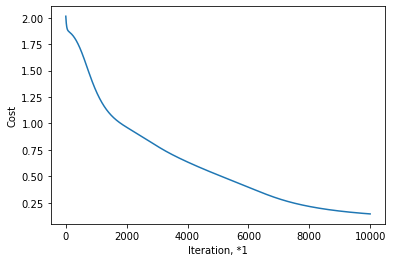

In [71]:
cls.fit(X, Y)

In [72]:
for parameter in cls.parameters:
    print("{} \t \n {} ".format(parameter, cls.parameters[parameter])) #cls.parameters[parameter].shape \t {} 

W_1 	 
 [[ 0.42096548  0.02832493 -1.74304268 -1.40673527]
 [ 0.1646274  -0.22915548  0.61383481  1.32719409]
 [ 0.0345421   1.06792305 -0.73933813 -1.15012744]
 [ 0.09072316 -1.07202095  1.19234381  0.46793846]] 
b_1 	 
 [[ 1.6383847 ]
 [-1.05949738]
 [-0.0575845 ]
 [ 0.15363748]] 
W_2 	 
 [[-0.99929566  1.91566121 -1.9243991   2.30428728]
 [-0.13173216 -1.77845666 -1.33460978 -0.25884256]
 [ 4.90820833 -2.32869112  1.94578948 -0.8990321 ]] 
b_2 	 
 [[ 0.69712658]
 [ 0.05946827]
 [-0.40292544]] 
W_3 	 
 [[-0.90511211 -1.27902624 -1.44098275]
 [ 4.77354744  0.44038879 -4.92038634]
 [-2.09320799  0.65132462  5.16343452]] 
b_3 	 
 [[ 0.45531686]
 [ 1.49053704]
 [-0.61085005]] 
W_4 	 
 [[ 0.14866251 -9.50758242  3.4994905 ]
 [-1.00864625  1.38732797  3.05697868]
 [ 0.78796303  7.39931314 -4.88595402]] 
b_4 	 
 [[ 3.09196565]
 [-0.65084013]
 [-2.44112552]] 


In [73]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[9.77870598e-01, 2.21264365e-02, 2.96511508e-06],
       [9.75026218e-01, 2.49702380e-02, 3.54438833e-06],
       [9.76868092e-01, 2.31287453e-02, 3.16278479e-06],
       [9.75850521e-01, 2.41461081e-02, 3.37129928e-06],
       [9.78094586e-01, 2.19024928e-02, 2.92090507e-06],
       [9.78226336e-01, 2.17707647e-02, 2.89925238e-06],
       [9.77433878e-01, 2.25630709e-02, 3.05073685e-06],
       [9.77503284e-01, 2.24936783e-02, 3.03788986e-06],
       [9.73789532e-01, 2.62066619e-02, 3.80586004e-06],
       [9.76186711e-01, 2.38099862e-02, 3.30312171e-06],
       [9.78204134e-01, 2.17929654e-02, 2.90062620e-06],
       [9.77427331e-01, 2.25696164e-02, 3.05284099e-06],
       [9.75546777e-01, 2.44497890e-02, 3.43447641e-06],
       [9.76251907e-01, 2.37448084e-02, 3.28453422e-06],
       [9.78589658e-01, 2.14075172e-02, 2.82499888e-06],
       [9.78654479e-01, 2.13427066e-02, 2.81441556e-06],
       [9.78370039e-01, 2.16270917e-02, 2.86967600e-06],
       [9.77723931e-01, 2.22730

In [74]:
Y_hat = cls.predict(X) # отримуємо масив з 0 та 1 
Y_hat = np.array(lb.inverse_transform(Y_hat)) # перетворюємо в значення класу, до якого належить приклад
print(Y_hat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [75]:
custom_accuracy = accuracy_score(Y, Y_hat)
custom_accuracy

0.98

# Scikit-learn Classifier

In [365]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000,  solver = 'adam') #, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [366]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(20,), max_iter=10000)

In [367]:
clf.predict_proba(X)

array([[9.93854692e-01, 6.14508225e-03, 2.25512666e-07],
       [9.84630633e-01, 1.53680693e-02, 1.29727053e-06],
       [9.90968229e-01, 9.03106063e-03, 7.10404384e-07],
       [9.83194735e-01, 1.68031147e-02, 2.15044885e-06],
       [9.94300661e-01, 5.69911404e-03, 2.25069090e-07],
       [9.92304218e-01, 7.69550828e-03, 2.73659899e-07],
       [9.90504357e-01, 9.49467488e-03, 9.68515937e-07],
       [9.90819342e-01, 9.18017410e-03, 4.83973515e-07],
       [9.80794539e-01, 1.92019565e-02, 3.50443474e-06],
       [9.85687834e-01, 1.43111690e-02, 9.96911115e-07],
       [9.94982448e-01, 5.01744297e-03, 1.09276534e-07],
       [9.87521865e-01, 1.24771286e-02, 1.00635797e-06],
       [9.86593793e-01, 1.34051726e-02, 1.03448874e-06],
       [9.90899556e-01, 9.09936402e-03, 1.08047122e-06],
       [9.98395627e-01, 1.60436262e-03, 1.02553826e-08],
       [9.98029489e-01, 1.97049036e-03, 2.09285600e-08],
       [9.97084183e-01, 2.91575639e-03, 6.02498172e-08],
       [9.93354233e-01, 6.64547

In [368]:
clf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [369]:
sk_accuracy = accuracy_score(Y, clf.predict(X))
sk_accuracy

0.98

In [370]:
print("Compare accuracy of custom and sklearn algorithm. \n")
res_compare_test = pd.DataFrame({'accuracy_custom' : [custom_accuracy], 'accuracy_sk' : [sk_accuracy], 'difference' : [abs(custom_accuracy - sk_accuracy)]})
print(res_compare_test)

Compare accuracy of custom and sklearn algorithm. 

   accuracy_custom  accuracy_sk  difference
0         0.986667         0.98    0.006667


In [371]:
clf.n_iter_

834